# `numpyro` implementation of a N-planet analysis

In [75]:
import jax
import jax.numpy as jnp
import numpyro

import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from astropy.table import Table
from jaxoplanet.orbits import keplerian
from jaxoplanet.units import unit_registry as ureg
from numpyro import distributions as dist, infer
from jax import jit  # Ensure JIT is imported

import yaml

In [76]:
numpyro.set_host_device_count(20)
jax.config.update("jax_enable_x64", True)

# Testing on a made-up dataset
We import the dataset from the file WITHOUT ACTIVITY. We do not consider the activity signal. We will model that later on with GPs. 

Goals: 
1. Find how many planets there is around the stars
2. Find their parameters

In [77]:
star_name = 'CRAPSTAR'
instrument = 'SpaceMuncher'
activity = 'without_activity'

tbl = Table.read(f'../data/lbl_{instrument}_{star_name}_{activity}.rdb', format='rdb') 
#get the file from the directory

time = tbl['rjd'] * ureg.days #reduced julian day
rv_obs = tbl['vrad'] * ureg.meter / ureg.second #vitesse radiale
rv_err = tbl['svrad'] * ureg.meter / ureg.second #incertitudes
err_guess = np.median(rv_err)

In [78]:
star = keplerian.Central(mass=0.1221, radius=0.24)

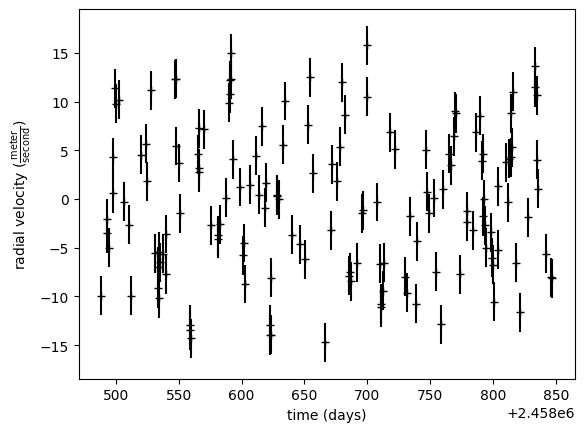

In [79]:
# Generate synthetic data in m/s
np.random.seed(12)
over_time = np.linspace(time.min(), time.max(), 1000)


def plot_data(wn = 0.0, offset = 0.0):
    plt.errorbar(time.magnitude, rv_obs.magnitude - offset, yerr=np.sqrt(rv_err.magnitude**2 + wn**2), fmt="+k")
    plt.xlabel("time (days)")
    plt.ylabel(f"radial velocity (${rv_obs.units:L}$)")

plot_data() #Plot the model based on the days and the radial velocities 

# General `jaxoplanet` model
Here I've done the jaxoplanet model for you. It predicts radial velocities given different model parameters. You can test different models by adding planets! 

In [80]:
@jit
def rv_model(time, params):
    system = keplerian.System(star)
    
    # 1st planet
    system = system.add_body(
        radial_velocity_semiamplitude=params["k1"] * ureg.m / ureg.s, 
        period=params["per1"] * ureg.days, 
        time_transit=params["tc1"] * ureg.days
    )
    
    # 2nd planet
    system = system.add_body(
        radial_velocity_semiamplitude=params["k2"] * ureg.m / ureg.s, 
        period=params["per2"] * ureg.days, 
        time_transit=params["tc2"] * ureg.days
    )
    
    # etc ... add more planets here
    
    # Calculate radial velocities for all bodies in one call
    signals = system.radial_velocity(time)

    # Sum contributions from all planets and return
    return signals.to(ureg.m / ureg.s).magnitude.sum(axis=0)


# Create the `jax_model` function

This function contains the priors and the likelihood (You can go look at the regression tutorial we did last time to get some inspiration)

In [87]:
def jax_model(time, rv_obs=None, rv_err=None):
    # Planet 1 
    # Paramter semi-amplitude
    k1 = numpyro.sample('k1', dist.Uniform(0, 100))
    
    # Parameter period
    per1 = numpyro.sample('per1', dist.Uniform(6, 12))

    # Paramter transit time
    tc1 = numpyro.sample('tc1', dist.Uniform(time.mean().magnitude - 6,time.mean().magnitude + 6))
    
    # Planet 2 
    # Paramter semi-amplitude
    k2 = numpyro.sample('k2', dist.Uniform(0, 100))
    
    # Parameter period
    per2 = numpyro.sample('per2', dist.Uniform(15, 26))

    # Paramter transit time
    tc2 = numpyro.sample('tc2', dist.Uniform(time.mean().magnitude - 11,time.mean().magnitude + 11))

    # Define white noise model
    wn = numpyro.sample('wn', dist.LogUniform(0.01, 10.0)) 
    #The noise we are adding it is bigger than 0.01 but smaller than 10, 
    #LogUniform: the probability between different orders to be the same. 
    #Ex. the uncertainty will be closer to 0.01-1 -> will explore smaller values first 
    
    params = {
        "k1": k1, "per1": per1, "tc1": tc1,
        "k2": k2, "per2": per2, "tc2": tc2,
    }

    # Expected value
    y_pred = rv_model(time, params)
    
    noise = jnp.sqrt(rv_err.magnitude**2 + wn**2)
    numpyro.sample('rv_obs', dist.Normal(y_pred, noise), obs=rv_obs.magnitude)

## Run the MCMC algorithm

In [88]:
# Define the number of warm-up steps, samples, and chains
ndim = 7
num_warmup = ndim * 100
num_samples = ndim * 1000
num_chains = 2

# Use NUTS sampler with initialization strategy set to predefined values
nuts_model = infer.NUTS(jax_model)
sampler = infer.MCMC(
    nuts_model,  # Initialize with the defined initial values
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=True,
)

# Ensure random seed is provided and compatible with JAX
seed = jax.random.PRNGKey(6)

# Run the sampler on the model with time and observed RV data
sampler.run(seed, time, rv_obs, rv_err)

# Summarize the results
sampler.print_summary()

  0%|          | 0/7700 [00:00<?, ?it/s]

  0%|          | 0/7700 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        k1      5.02      0.25      5.01      4.60      5.42  12074.12      1.00
        k2      7.99      0.23      7.99      7.59      8.35  14941.97      1.00
      per1      9.00      0.01      9.00      8.99      9.01  17151.47      1.00
      per2     21.99      0.02     21.99     21.95     22.03  13550.51      1.00
       tc1 2458664.93      0.07 2458664.93 2458664.83 2458665.04  13504.25      1.00
       tc2 2458662.09      0.11 2458662.09 2458661.91 2458662.27  13749.68      1.00
        wn      0.24      0.28      0.12      0.01      0.67   9791.56      1.00

Number of divergences: 0


In [89]:
samples = sampler.get_samples()
best_params = {k: jnp.median(v) for k, v in samples.items()}
print(best_params)

{'k1': Array(5.01304553, dtype=float64), 'k2': Array(7.98918544, dtype=float64), 'per1': Array(9.00113848, dtype=float64), 'per2': Array(21.9882423, dtype=float64), 'tc1': Array(2458664.93461312, dtype=float64), 'tc2': Array(2458662.08866749, dtype=float64), 'wn': Array(0.11725426, dtype=float64)}


## Make the cornerplot
 (which shows the mountain of probability)

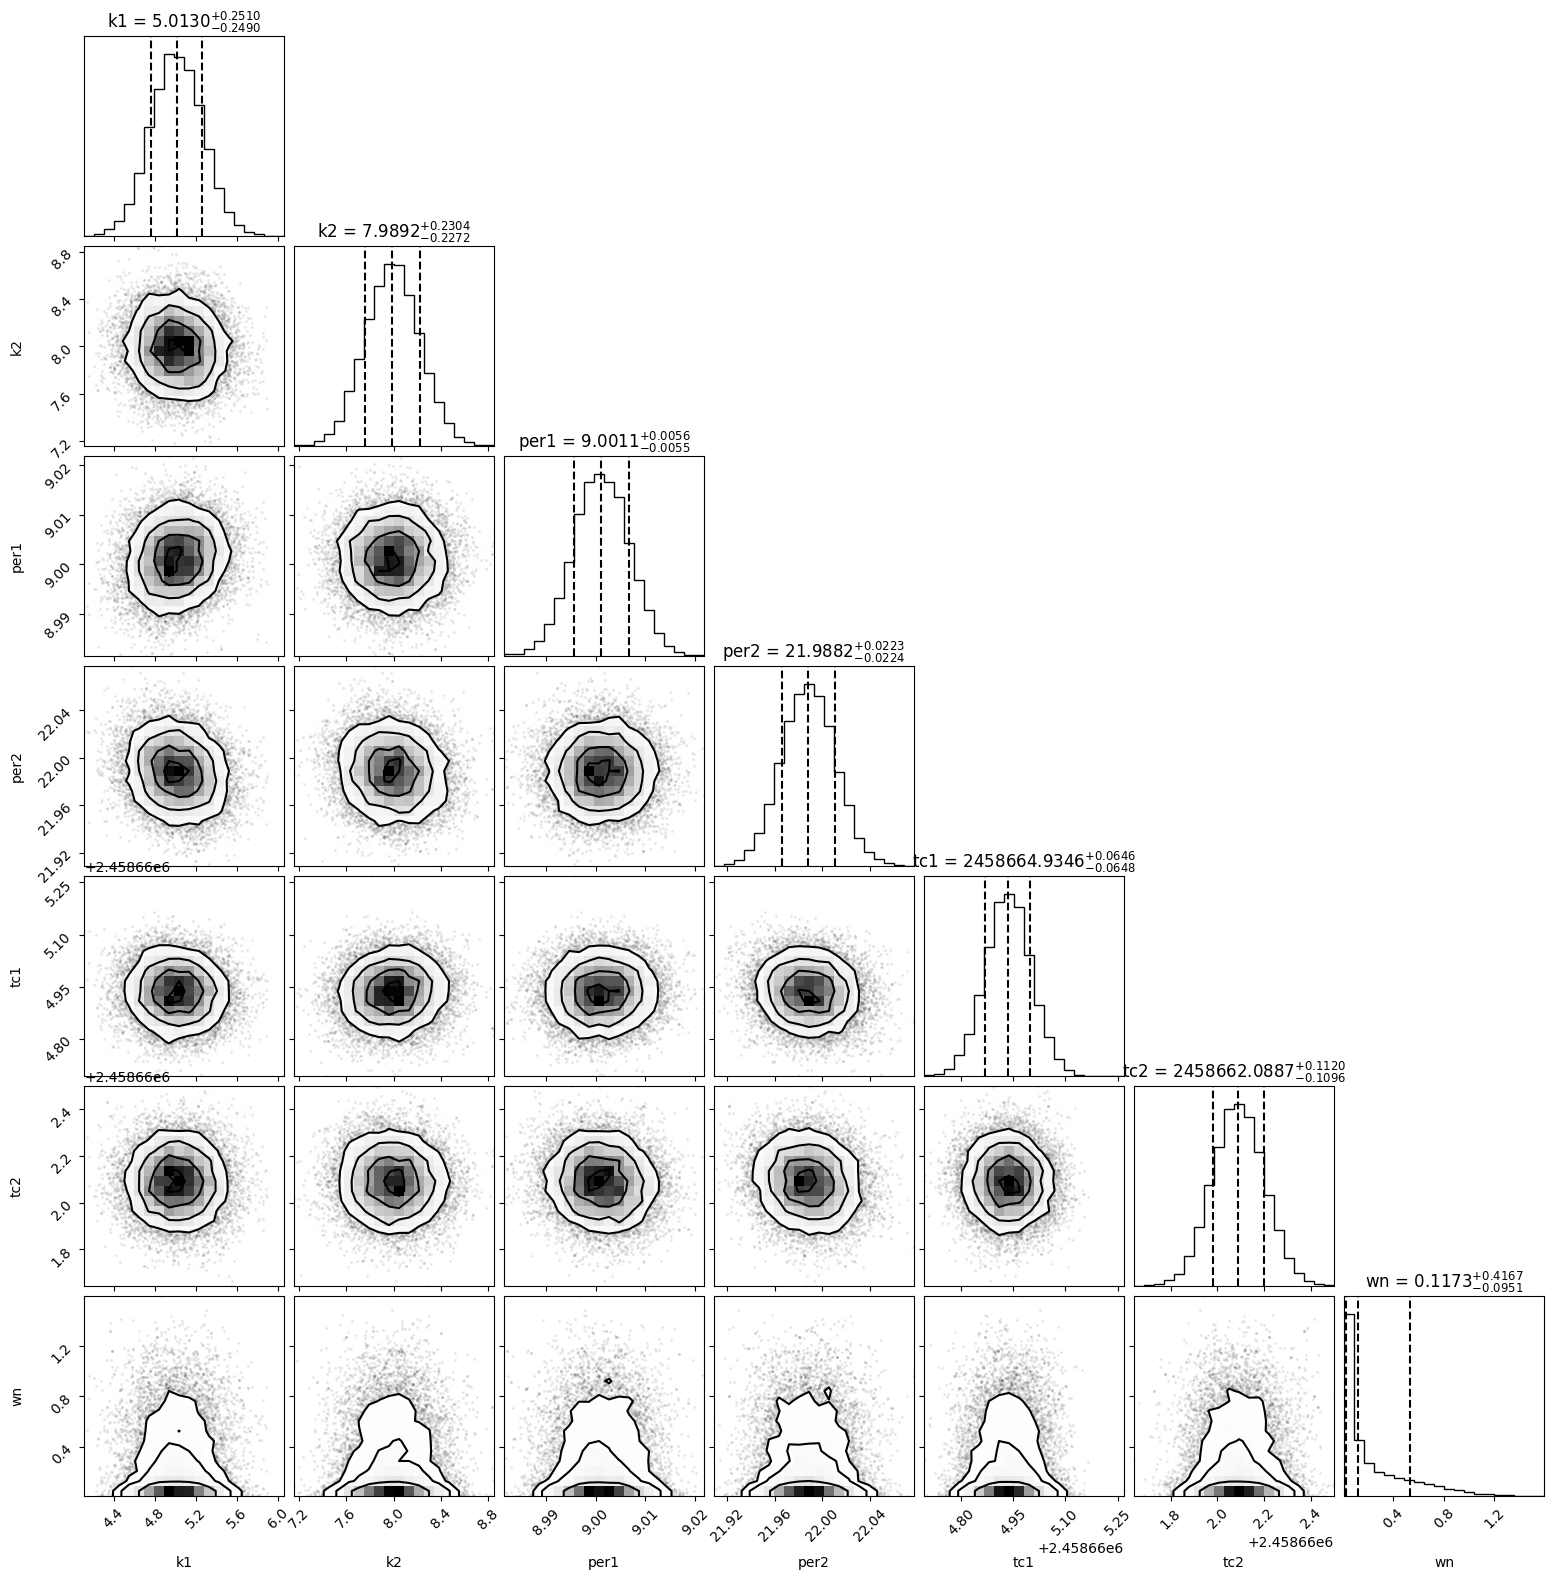

In [90]:
import corner

_ = corner.corner(
    samples,
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_fmt=".4f",
)

## Best-fit graph
Show what the best-fit model looks like on the data

In [85]:
time.min()

<Quantity(2458488.185484, 'day')>

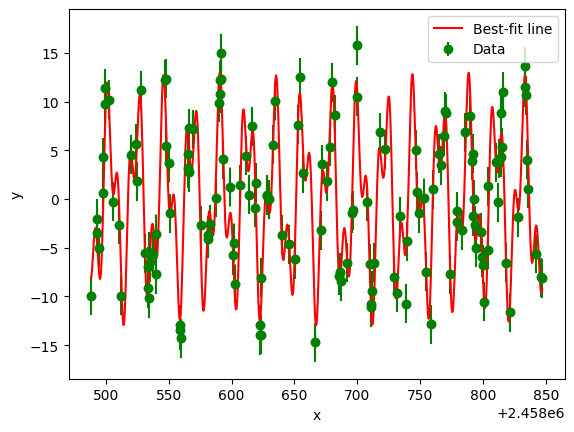

In [93]:
# Generate best-fit line
time_fit = np.linspace(time.min(), time.max(), 1000)
y_fit = rv_model(time_fit, best_params)

# Plot the data points with regular error bars
plt.errorbar(time, rv_obs.magnitude, rv_err.magnitude, fmt='o', label='Data', color='green')

# Plot the data points with white noise model error bars
plt.errorbar(time, rv_obs.magnitude, np.sqrt(rv_err.magnitude**2 + best_params["wn"]**2), fmt='o', color='green', alpha = 0.5)

# Plot the best-fit line
plt.plot(time_fit, y_fit, label='Best-fit line', color='red')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()